In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv


In [2]:
import math
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import  Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
data = pd.read_csv("../input/tesla-stock-price/Tesla.csv - Tesla.csv.csv",index_col='Date', parse_dates=True)

In [4]:
data

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...
2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996


In [5]:
# Resample the data to yearly frequency and count the number of days per year
days_per_year = data.resample('Y').count()

# Display the result
print(days_per_year)

            Open  High  Low  Close  Volume  Adj Close
Date                                                 
2010-12-31   130   130  130    130     130        130
2011-12-31   252   252  252    252     252        252
2012-12-31   250   250  250    250     250        250
2013-12-31   252   252  252    252     252        252
2014-12-31   252   252  252    252     252        252
2015-12-31   252   252  252    252     252        252
2016-12-31   252   252  252    252     252        252
2017-12-31    52    52   52     52      52         52


In [6]:
data.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


# ***we will work on closing price ***

In [7]:
close_data = data.iloc[:, 3:4]

In [8]:
close_data

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2017-03-13,246.169998
2017-03-14,258.000000
2017-03-15,255.729996


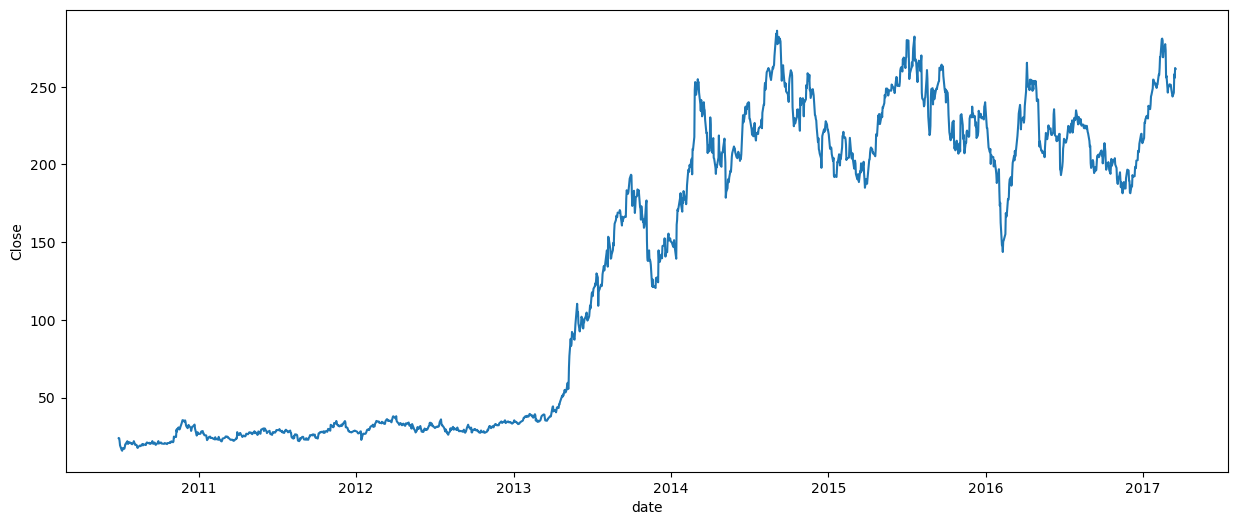

In [9]:
# Plot the data
plt.plot(close_data)
plt.xlabel('date')
plt.ylabel('Close')
plt.show()

In [10]:
# Apply the Augmented Dickey-Fuller test
result = adfuller(close_data['Close'])

# Print the test statistic and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.813733
p-value: 0.815055


p value >0.05 so we try differencing the data

ADF Statistic: -0.813733
p-value: 0.815055
ADF Statistic: -39.848280
p-value: 0.000000
ADF Statistic: -14.448064
p-value: 0.000000


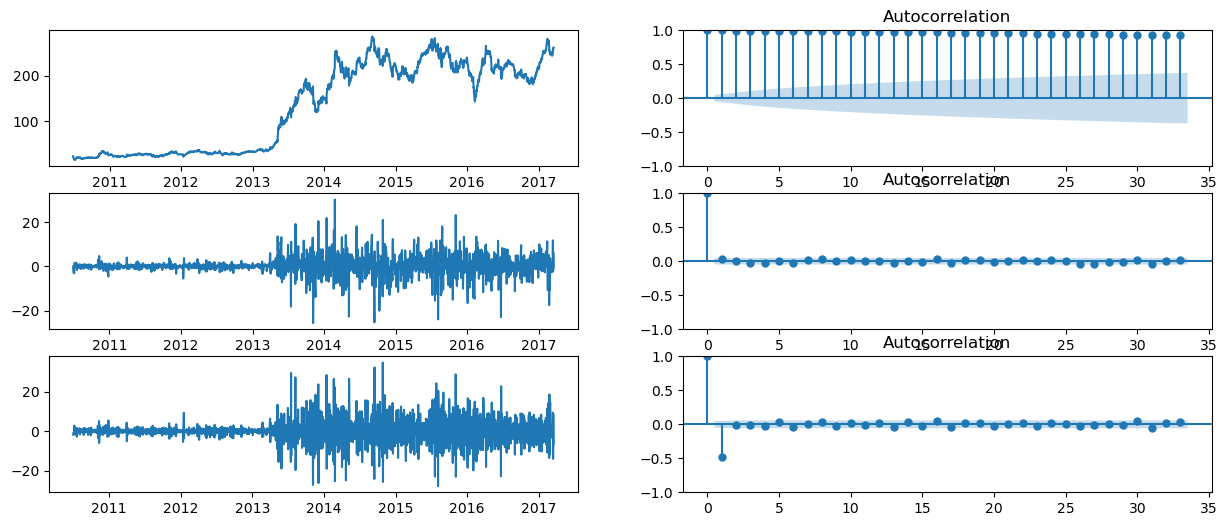

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


# Apply differencing to the data


# Create a grid of subplots
fig, axes = plt.subplots(3, 2)
 
# Plot the autocorrelation function for the differenced data three times
df=close_data
for i in range(3):
    axes[i,0].plot(df) 
    plot_acf(df['Close'], ax=axes[i,1])
    # Apply the Augmented Dickey-Fuller test
    result = adfuller(df['Close'])
    # Print the test statistic and p-value
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    df = df.diff().dropna()

plt.show()


****with difference equal to 1 the data become stationary****

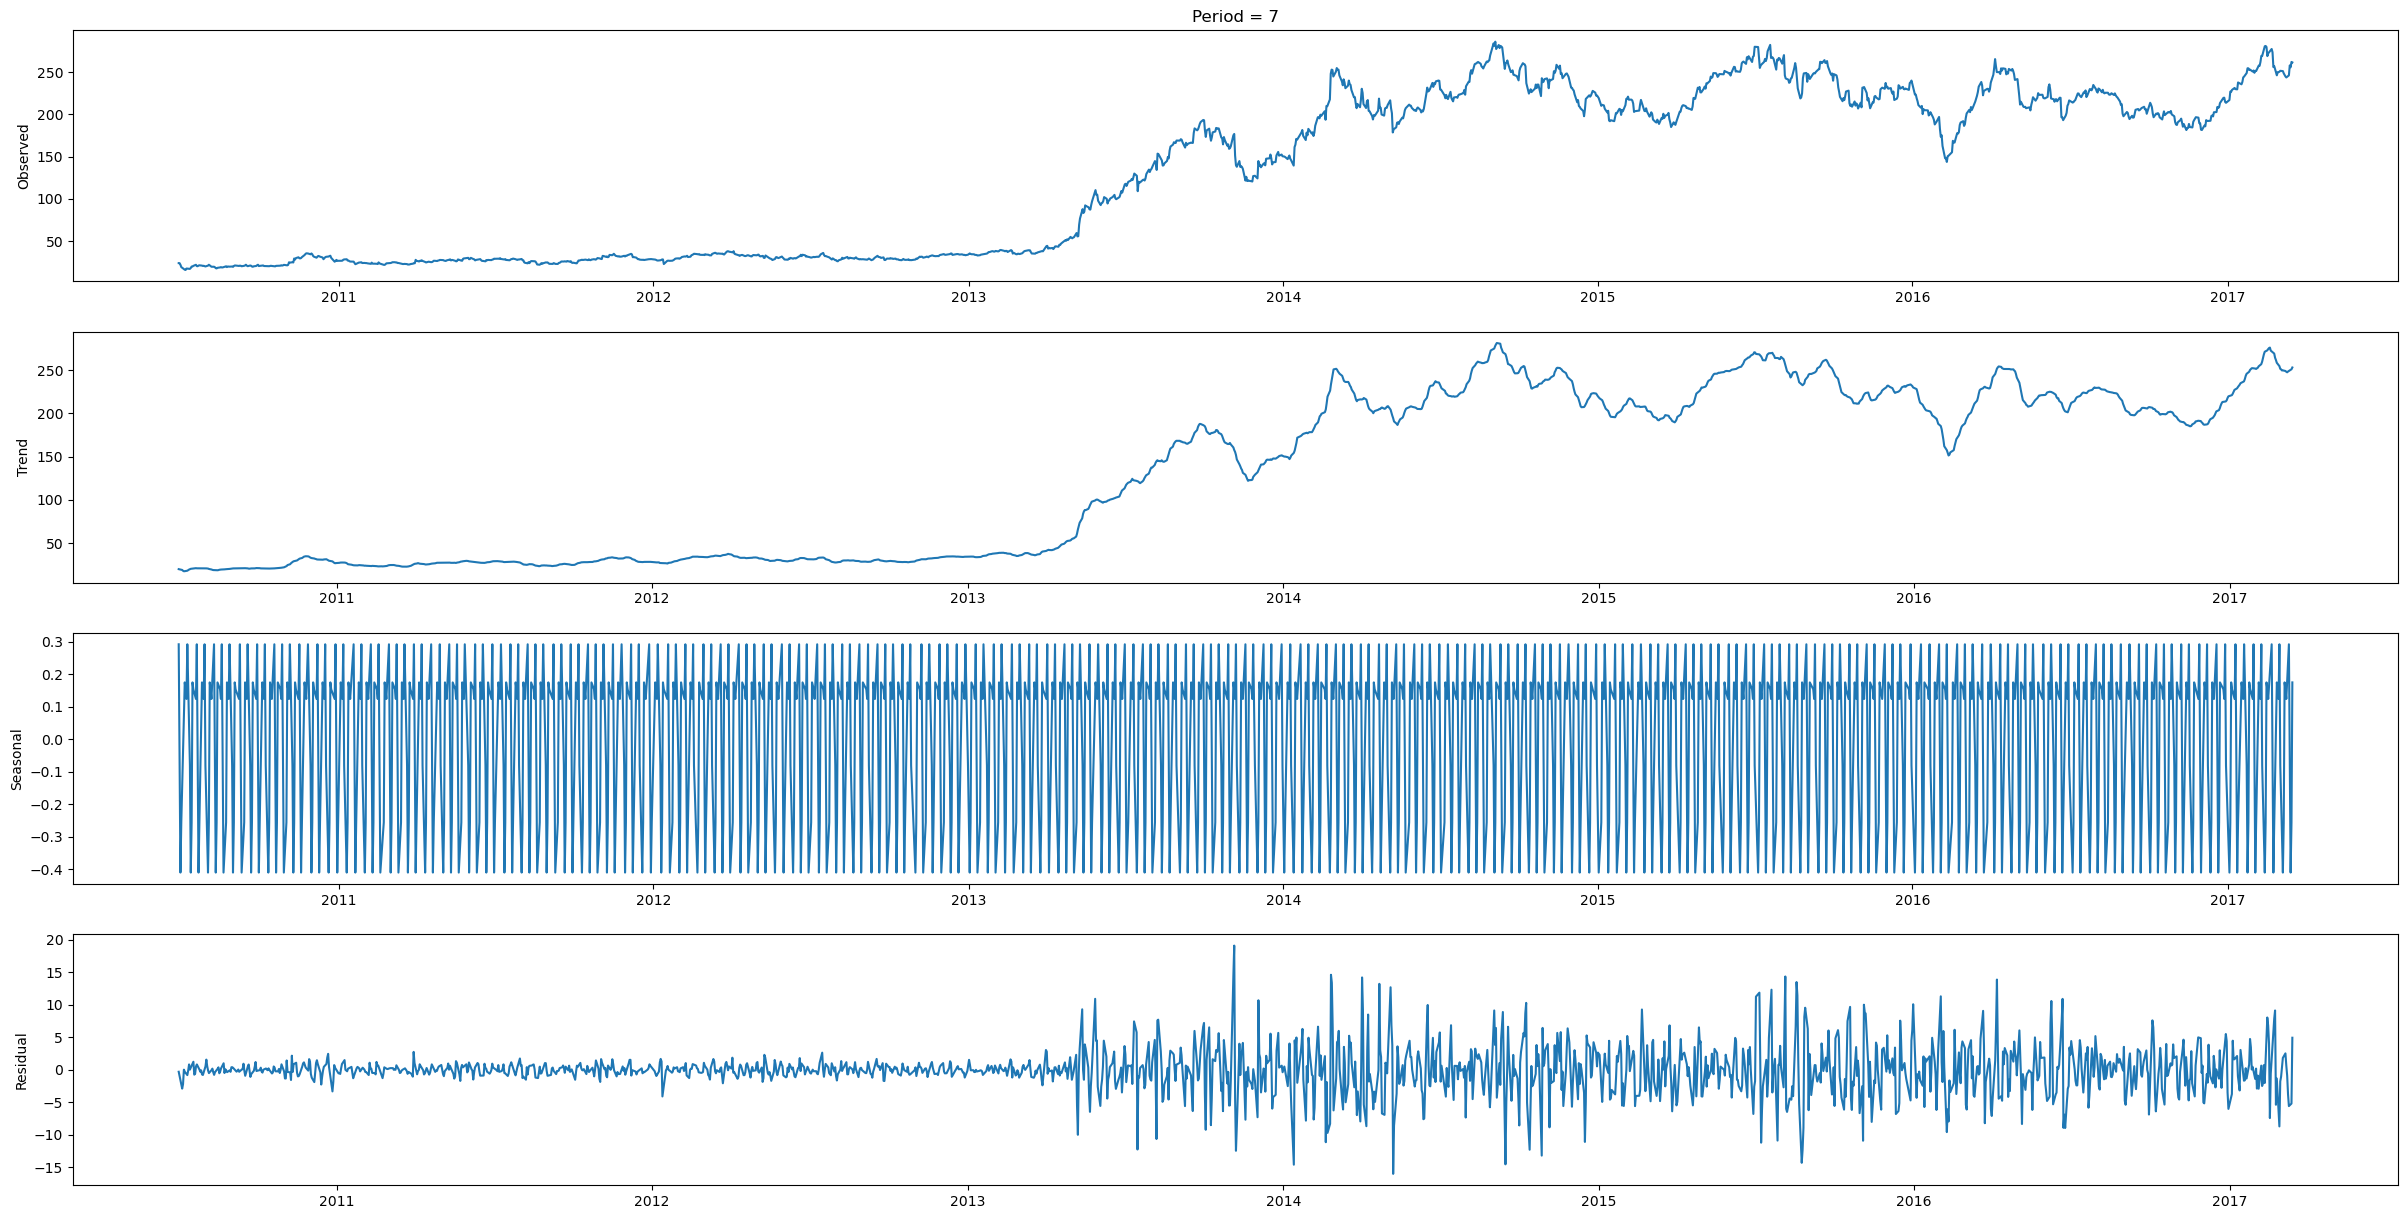

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Create a list of period values to use
periods = [7]

# Create a figure with 4 subplots arranged in a single row
fig, axes = plt.subplots(nrows=4, ncols=len(periods), figsize=(30, 15))

# Loop over the period values
for i, period in enumerate(periods):
    # Decompose the time series data into trend, seasonal, and residual components
    decomposition = seasonal_decompose(close_data, period=period)
    
    # Plot the observed data on the first row of subplots
    axes[0].plot(decomposition.observed)
    axes[0].set_title(f'Period = {period}')
    
    # Plot the trend component on the second row of subplots
    axes[1].plot(decomposition.trend)
    
    # Plot the seasonal component on the third row of subplots
    axes[2].plot(decomposition.seasonal)
    
    # Plot the residual component on the fourth row of subplots
    axes[3].plot(decomposition.resid)

# Set the titles for each row of subplots
axes[0].set_ylabel('Observed')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')

# Display the figure
plt.show()


In [13]:
# Apply the Ljung-Box test
ljung_box_results = acorr_ljungbox(close_data['Close'])

# Print ljung_box_results
print('ljung_box_results:', ljung_box_results)

if len(ljung_box_results) > 0:
    print('Ljung-Box test statistics:', ljung_box_results[0])
    print('p-values:', ljung_box_results[1])
else:
    print('ljung_box_results is empty')


ljung_box_results:          lb_stat  lb_pvalue
1    1688.128238        0.0
2    3370.143218        0.0
3    5046.187770        0.0
4    6716.296180        0.0
5    8380.932812        0.0
6   10040.097643        0.0
7   11694.008483        0.0
8   13342.488433        0.0
9   14985.196881        0.0
10  16622.045496        0.0


KeyError: 0

In [131]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_model(X, seasonal_order):
    # prepare training dataset
    train_size = int(len(X) * 0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    # Seasonal - fit stepwise auto-ARIMA
    model = ARIMA(train, order=(3, 1, 2))
    model_fit = model.fit()
    predicted_values = model_fit.fittedvalues
    
    r2t=r2_score(train, predicted_values)
    predictions  = model_fit.forecast(steps=len(test))
    r2 = r2_score(test, predictions)
    return r2,r2t,test,predictions,model_fit


In [132]:
ariama_data=close_data.iloc[:close_data.shape[0]-60,:]
r2,r2t,test, arima_predictions,arima_model = sarima_model(ariama_data['Close'],(1,1,1,12))




/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [133]:
from math import sqrt

In [134]:
rmse = sqrt(mean_squared_error(arima_predictions, test))
rmse

364.7593806667989

In [135]:
r2

-130.50545748822964

In [136]:
r2t

0.9957785256565294

# ARIMA predection for the next 60 days

In [137]:
def arima_predict(res_set,arima_model,steps):
    predictions = list(arima_model.forecast(steps=steps))
    r2 = r2_score(res_set, predictions)
    rmse = sqrt(mean_squared_error(predictions, res_set))
    return predictions, r2,rmse


In [138]:
res_set=close_data.iloc[-60:,:]

In [139]:
predictions,r2,rmse=arima_predict(res_set,arima_model,60)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [140]:
r2,rmse

(-2.7816017407775533, 36.753165158524276)

In [141]:
predictionss = pd.DataFrame(predictions, columns=['Close'])
predictionss = predictionss.set_index(res_set.reset_index()['Date'])

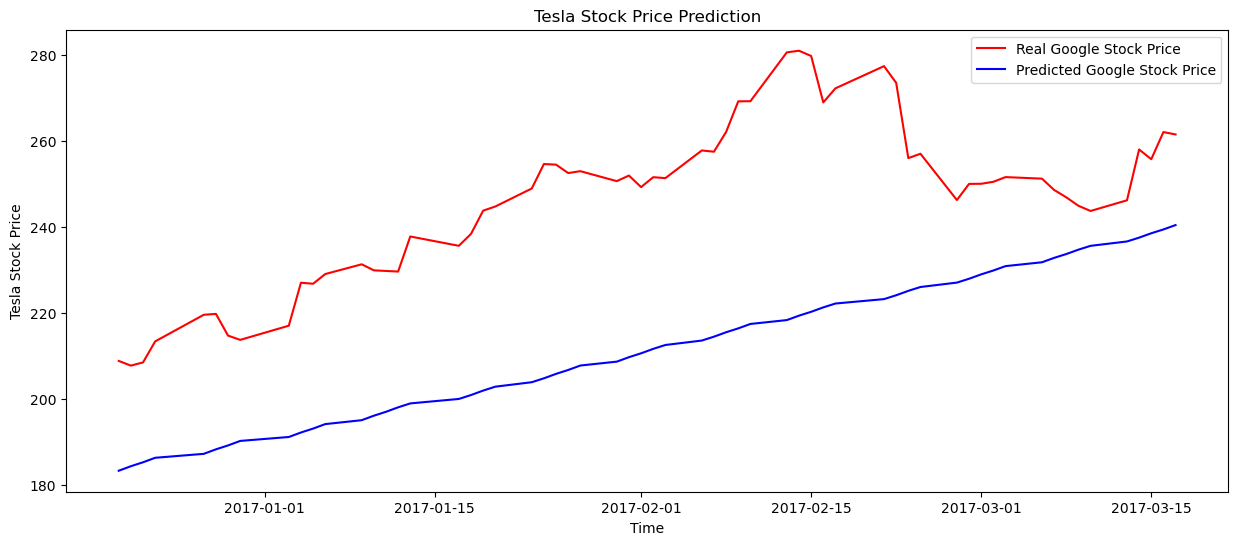

In [143]:
# Visualising the results
plt.plot(res_set, color = 'red', label = 'Real Google Stock Price')
plt.plot(predictionss, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [147]:
predictionsss = pd.DataFrame(arima_predictions.tolist(), columns=['Close'])
predictionsss = predictionsss.set_index(test.reset_index()['Date'])

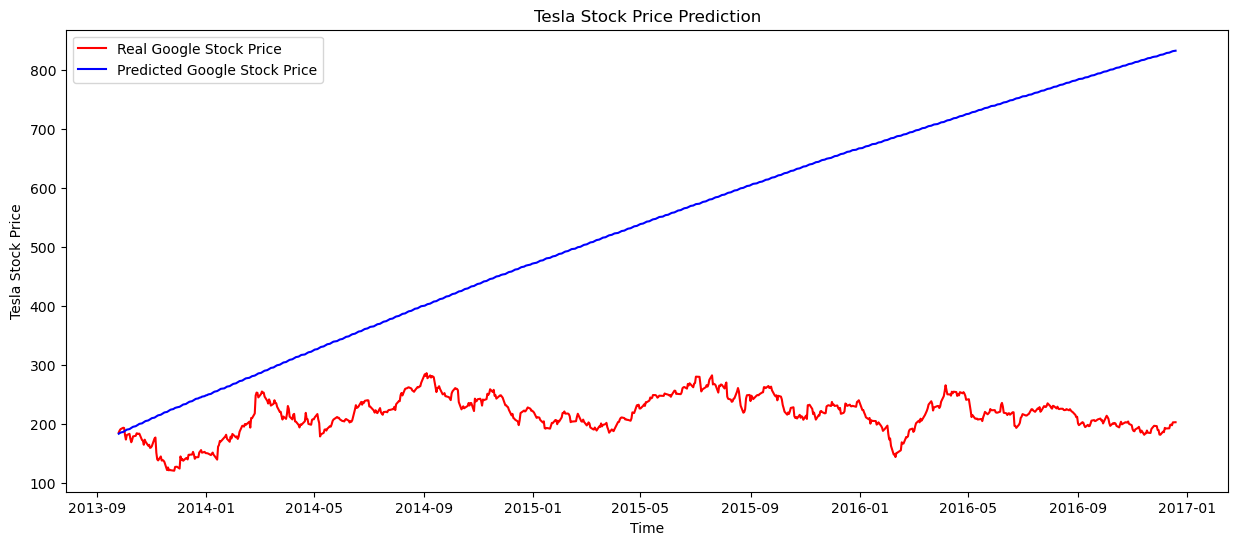

In [148]:
# Visualising the results
plt.plot(test, color = 'red', label = 'Real Google Stock Price')
plt.plot(predictionsss, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

# ARIMA & LSTM hybrid model 

In [263]:
n_steps=70


In [264]:

# Prepare data for LSTM model
def prepare_data(x, y, n_steps):
    X, Y = [], []
    for i in range(len(x) - n_steps):
        seq_x = x[i:i+n_steps]
       
        seq_y = y[i+n_steps-1]
     
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)



X_train, y_train = prepare_data(arima_predictions,test,n_steps)

In [265]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Define LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64))

model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')




In [266]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=6, verbose=1,min_lr=1e-9)

In [267]:
# Fit LSTM model
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
24/24 [==============================] - 6s 107ms/step - loss: nan
Epoch 2/30
24/24 [==============================] - 3s 112ms/step - loss: nan
Epoch 3/30
24/24 [==============================] - 3s 106ms/step - loss: nan
Epoch 4/30
 1/24 [>.............................] - ETA: 2s - loss: nan


KeyboardInterrupt



In [253]:

# Make predictions with LSTM model
history = arima_predictions[-n_steps:]
lstm_predictions = []
for i in range(len(predictions)):
    x_input = np.array(history[-n_steps:])
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input = x_input.astype('float32')
    yhat = model.predict(x_input,verbose=0)[0][0]
    lstm_predictions.append(yhat)
    history.append(pd.Series(predictions[i]))


In [256]:
r2 = r2_score(res_set, lstm_predictions)

ValueError: Input contains NaN.

In [257]:
r2

-4.118899699567297

In [258]:
rmse = sqrt(mean_squared_error(res_set, lstm_predictions))

ValueError: Input contains NaN.

In [201]:
rmse

42.76073500400079

In [259]:
lstm_predictions = pd.DataFrame(lstm_predictions, columns=['Close'])


In [260]:
lstm_pre
dictions = lstm_predictions.set_index(res_set.reset_index()['Date'])

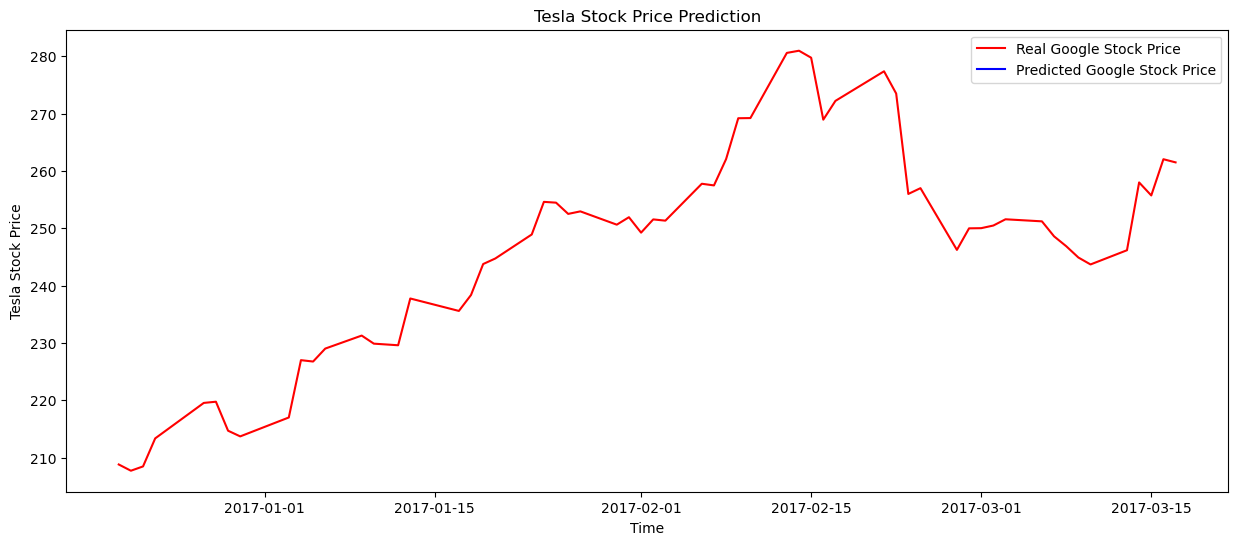

In [261]:
# Visualising the results
plt.plot(res_set, color = 'red', label = 'Real Google Stock Price')
plt.plot(lstm_predictions, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [205]:
l=[1,2,3,4]
l[0:3]

[1, 2, 3]